In [1]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.2 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from tqdm import tqdm
import resampy

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense , Activation , Dropout , SpatialDropout2D, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, ReLU, Flatten
from keras.optimizers import Adam

from keras import backend as keras_backend
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import seaborn as sns
import random
import math

from glob import glob
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [3]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('/content/drive/MyDrive/ThesisData/', 'File'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [4]:
df = create_dataset_df('/content/drive/MyDrive/ThesisData/ThesisLionMD.csv')

In [ ]:
len(df)

3480

In [5]:
def get_duration(file_name):

    # load the audio file
    audio,sample_rate = librosa.load(file_name,res_type='kaiser_fast')

    time = librosa.get_duration(y=audio, sr=sample_rate)

    return time

In [6]:
duration = []

for index_num, row in tqdm(df.iterrows()):

    # get the file
    file_name = os.path.join(os.path.abspath('drive/MyDrive/ThesisData/'),'File'+str(row["fold"])+'/',str(row['slice_file_name']))

    time = get_duration(file_name)

    duration.append(time)

3480it [14:31,  3.99it/s]


In [7]:
df['duration'] = duration
sorted_df = df[df.duration <= 3]
sorted_df['class'].value_counts()

Grunt    1491
Roar      993
IRoar     987
Name: class, dtype: int64

In [8]:
len(sorted_df)

3471

In [9]:
class_map = {'1' : 'IRoar', '0' : 'Roar', '2' : 'Grunt'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,Roar
1,1,IRoar
2,2,Grunt


In [10]:
appended = []
for i in range(1,4):
    appended.append(sorted_df[sorted_df.fold == i]['class'].value_counts())

class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,4)]
class_distribution

,index,Grunt,Roar,IRoar
0,fold1,496,332,326
1,fold2,496,329,329
2,fold3,499,332,332


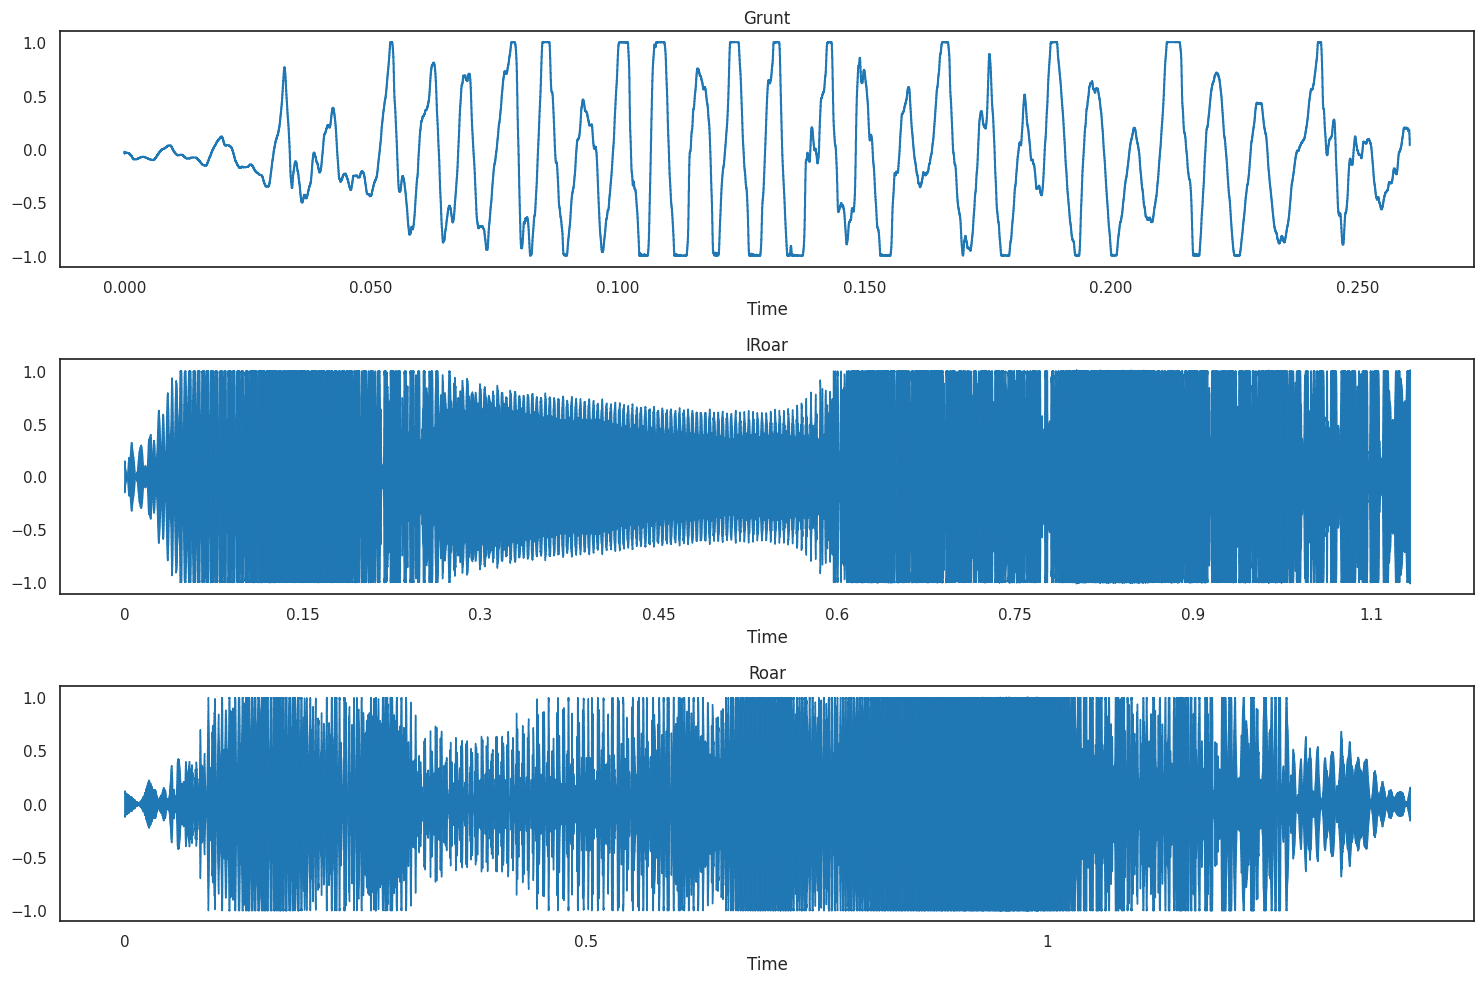

In [11]:
# Randomly select one sample of each class
random_samples = sorted_df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(3, 1, figsize=(15,10))
index = 0
for col in range(3):
    audio_file, sample_rate = librosa.load(audio_samples[index])
    librosa.display.waveshow(y=audio_file, sr=sample_rate, ax=axs[col])
    axs[col].set_title('{}'.format(labels[index]))
    index += 1
fig.tight_layout()

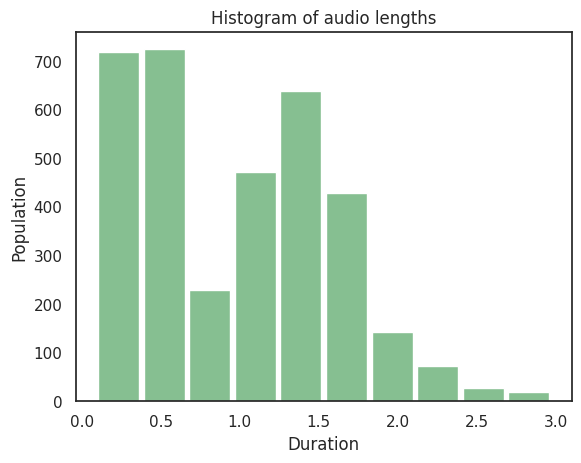

Greater than 3 seconds: 0
Lower than 3 but greater than 2 seconds: 152
Lower than 2 but greater than 1 seconds: 1601
Lower than 1 seconds: 1718


In [12]:
plt.hist(sorted_df['duration'], rwidth=0.9, color='#86bf91')

plt.xlabel('Duration')
plt.ylabel('Population')
plt.title('Histogram of audio lengths')
plt.grid(False)
plt.show()

# Count samples with duration > 3 sec
gt_3sec = sorted_df['duration'][(sorted_df['duration'] > 3)].count()
gt_2sec = sorted_df['duration'][(sorted_df['duration'] > 2) & (sorted_df['duration'] < 3)].count()
lt_2sec = sorted_df['duration'][(sorted_df['duration'] > 1) & (sorted_df['duration'] < 2)].count()
lt_1sec = sorted_df['duration'][sorted_df['duration'] < 1].count()

# Display counts of interest
print("Greater than 3 seconds: {}".format(gt_3sec))
print("Lower than 3 but greater than 2 seconds: {}".format(gt_2sec))
print("Lower than 2 but greater than 1 seconds: {}".format(lt_2sec))
print("Lower than 1 seconds: {}".format(lt_1sec))

In [19]:
# Feature extraction using librosa

x_train=[]
x_test=[]
y_train=[]
y_test=[]

path='/content/drive/MyDrive/ThesisData/File'
for i in tqdm(range(len(df))):
    fold_no=str(df.iloc[i]["fold"])
    file=df.iloc[i]["slice_file_name"]
    label=df.iloc[i]["classID"]
    filename=path+fold_no+"/"+file
    y,sr=librosa.load(filename, res_type='kaiser_fast')
    #trim the audio file
    y_trimmed, _ = librosa.effects.trim(y)
    mfccs = np.mean(librosa.feature.mfcc(y=y_trimmed[0:2000], sr=sr, n_mfcc=40).T,axis=0)
    melspectrogram = np.mean(librosa.feature.melspectrogram(y=y_trimmed[0:2000], sr=sr, n_mels=40,fmax=8000).T,axis=0)
    chroma_stft=np.mean(librosa.feature.chroma_stft(y=y_trimmed[0:2000], sr=sr,n_chroma=40).T,axis=0)

    features=np.reshape(np.vstack((mfccs,melspectrogram,chroma_stft)),(40,3))
    if(fold_no!='3'):
      x_train.append(features)
      y_train.append(label)
    else:
      x_test.append(features)
      y_test.append(label)

  0%|          | 5/3480 [00:00<02:53, 20.06it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
  5%|▌         | 176/3480 [00:11<02:38, 20.83it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1999
  warnings.warn(
100%|██████████| 3480/3480 [04:01<00:00, 14.40it/s]


In [20]:
x=x_train+x_test
y=y_train+y_test

In [21]:
x=np.array(x)
y=np.array(y)
x.shape,y.shape

((3480, 40, 3), (3480,))

In [22]:
#reshaping into 2d to save in csv format
x_2d=np.reshape(x,(x.shape[0],x.shape[1]*x.shape[2]))
x_2d.shape
#saving the data numpy arrays
np.savetxt("x.csv", x_2d, delimiter=",")
np.savetxt("y.csv",y,delimiter=",")

In [26]:
import math

indexes = []
total = len(df)
indexes = list(range(0, total))
# Randomize indexes random.shuffle(indexes)
# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)
# Split the data
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]
# Split the features with the same indexes
X_test = np.take(x, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(x, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)
# Also split metadata
test = df.iloc[test_split_idx]
train = df.iloc[train_split_idx]
# Print status
print("Test split: {} \t\t Train split: {}".format(len(test), len(train)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 696 		 Train split: 2784
X test shape: (696, 40, 3) 	 X train shape: (2784, 40, 3)
y test shape: (696,) 		 y train shape: (2784,)


In [27]:
#converting to one hot
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)
y_train.shape,y_test.shape

((2784, 3), (696, 3))

In [28]:
#reshaping to 2D
X_train=np.reshape(X_train,(X_train.shape[0], 40,3))
X_test=np.reshape(X_test,(X_test.shape[0], 40,3))
X_train.shape,X_test.shape

((2784, 40, 3), (696, 40, 3))

In [29]:
#reshaping to shape required by CNN
X_train=np.reshape(X_train,(X_train.shape[0], 40,3,1))
X_test=np.reshape(X_test,(X_test.shape[0], 40,3,1))
X_train.shape,X_test.shape

((2784, 40, 3, 1), (696, 40, 3, 1))

In [30]:
model=Sequential()
#adding layers and forming the model
model.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="elu",input_shape=(40,3,1)))
model.add(MaxPooling2D(padding="same"))
model.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="elu"))
model.add(MaxPooling2D(padding="same"))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256,activation="elu"))
model.add(Dropout(0.3))
model.add(Dense(512,activation="elu"))
model.add(Dropout(0.3))
model.add(Dense(3,activation="softmax"))

In [31]:
#compiling
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
#training the model
model.fit(X_train,y_train,batch_size=50,epochs=30,validation_data=(X_test,y_test))

Epoch 1/30
56/56 [==============================] - 8s 107ms/step - loss: 4.8380 - accuracy: 0.5826 - val_loss: 0.7602 - val_accuracy: 0.7069
Epoch 2/30
56/56 [==============================] - 7s 128ms/step - loss: 1.2253 - accuracy: 0.6462 - val_loss: 0.6456 - val_accuracy: 0.7443
Epoch 3/30
56/56 [==============================] - 7s 116ms/step - loss: 0.8979 - accuracy: 0.6616 - val_loss: 0.6421 - val_accuracy: 0.7256
Epoch 4/30
56/56 [==============================] - 6s 106ms/step - loss: 0.7914 - accuracy: 0.6825 - val_loss: 0.6728 - val_accuracy: 0.7284
Epoch 5/30
56/56 [==============================] - 8s 142ms/step - loss: 0.7577 - accuracy: 0.6958 - val_loss: 0.6834 - val_accuracy: 0.6624
Epoch 6/30
56/56 [==============================] - 6s 103ms/step - loss: 0.7503 - accuracy: 0.6922 - val_loss: 0.5665 - val_accuracy: 0.7486
Epoch 7/30
56/56 [==============================] - 8s 143ms/step - loss: 0.7044 - accuracy: 0.7026 - val_loss: 0.5717 - val_accuracy: 0.7557
Epoch 

In [32]:
#train and test loss and scores respectively
train_loss_score=model.evaluate(X_train,y_train)
test_loss_score=model.evaluate(X_test,y_test)
print(train_loss_score)
print(test_loss_score)

22/22 [==============================] - 0s 16ms/step - loss: 0.5276 - accuracy: 0.7845
[0.44905781745910645, 0.8175287246704102]
[0.5276461243629456, 0.7844827771186829]


In [33]:
# Predict probabilities for test set
y_probs = model.predict(X_test)
# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test, axis=1)
# Add "pred" column
test['pred'] = yhat_probs

22/22 [==============================] - 1s 18ms/step


<ipython-input-33-1235db5f3c9d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = yhat_probs


In [34]:
np.set_printoptions(precision=2)
# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)
print(cm)

[[108  27  40]
 [ 18 183   6]
 [ 56   3 255]]


In [35]:
# Define a labels array for future use
labels = [ 'Roar' , 'IRoar' , 'Grunt' ]
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2], target_names=labels)
print(re)

              precision    recall  f1-score   support

        Roar       0.59      0.62      0.61       175
       IRoar       0.86      0.88      0.87       207
       Grunt       0.85      0.81      0.83       314

    accuracy                           0.78       696
   macro avg       0.77      0.77      0.77       696
weighted avg       0.79      0.78      0.79       696



In [36]:
# Set your path to the dataset
audio_path = os.path.abspath('/content/drive/MyDrive/ThesisData')

In [37]:
test.head()

,fs_id,slice_file_name,classID,fold,class,filepath,duration,pred
0,iroar_123,iroar_123.wav,1,1,IRoar,/content/drive/MyDrive/ThesisData/File1/iroar_...,1.785488,1
1,iroar_308,iroar_308.wav,1,1,IRoar,/content/drive/MyDrive/ThesisData/File1/iroar_...,1.264354,1
2,grunt_878,grunt_878.wav,2,2,Grunt,/content/drive/MyDrive/ThesisData/File2/grunt_...,0.303628,0
3,roar_178,roar_178.wav,0,1,Roar,/content/drive/MyDrive/ThesisData/File1/roar_1...,1.393515,0
4,roar_963,roar_963.wav,0,3,Roar,/content/drive/MyDrive/ThesisData/File3/roar_9...,1.407211,0


In [38]:
# Find the target misclassified ocurrencies
grunt_as_roar = test[(test['classID'] == 2) & (test['pred'] == 0)]
files = []
for idx, row in grunt_as_roar.iterrows(): fold_num = str(row['fold'])
file_name = row['slice_file_name']
category = row['class']
file_path = audio_path + '/File'+ fold_num +'/' + file_name
files.append(file_path)
print("Lion Grunts as Lion Roars: {} ocurrencies".format(len(grunt_as_roar)))
# Manully set the file index
index = 24
# Display results
print("\nTrue category: {}".format(category))

Lion Grunts as Lion Roars: 66 ocurrencies

True category: Grunt
